In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10


c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\umap\umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [3]:
import os

os.getcwd()
os.chdir("/Users/malon/OneDrive/Documents/GitHub/Maloney1/data/filtered_feature_bc_matrix_wheelsoff")

In [4]:
file_location = "/Users/malon/OneDrive/Documents/GitHub/Maloney1/data/pbmc3k_filtered_gene_bc_matrices.tar.gz"

In [5]:
# !tar -xzvf /Users/malon/OneDrive/Documents/GitHub/Maloney1/data/pbmc3k_filtered_gene_bc_matrices.tar.gz

In [6]:
input_file = "C:/Users/malon/OneDrive/Documents/GitHub/Maloney1/data/filtered_feature_bc_matrix_wheelsoff"
results_file = "/Users/malon/OneDrive/Documents/GitHub/Maloney1/write/wheels_off.h5ad"  # the file that will store the analysis results

adata = sc.read_10x_mtx(
    input_file,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    )                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


normalizing counts per cell
    finished (0:00:00)


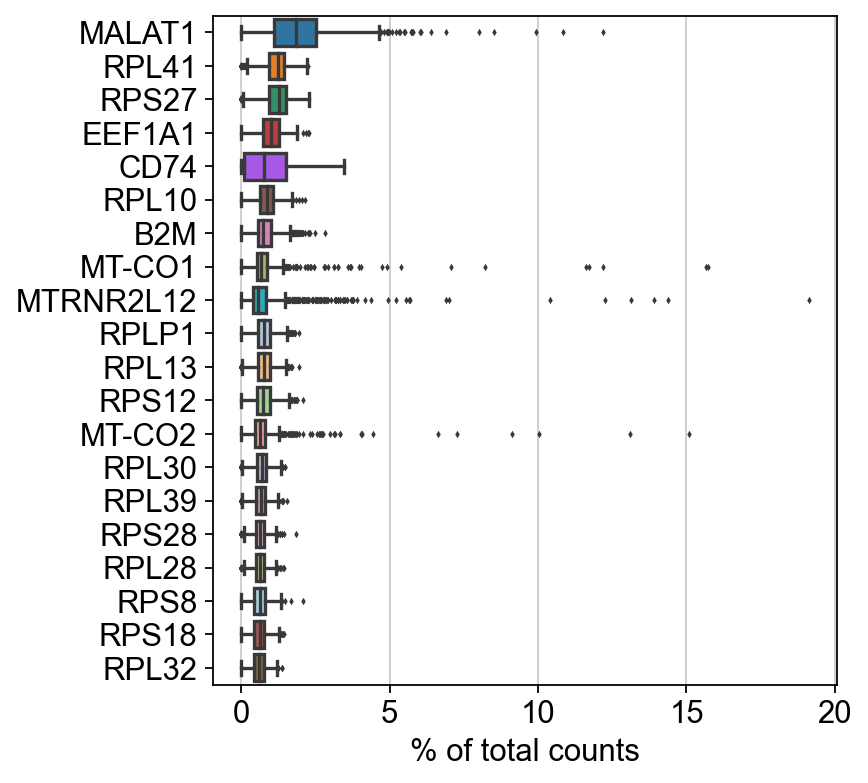

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3 cells that have less than 200 genes expressed


filtered out 18784 genes that are detected in less than 3 cells


In [9]:
#Mitochondrial genes for quality control.

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


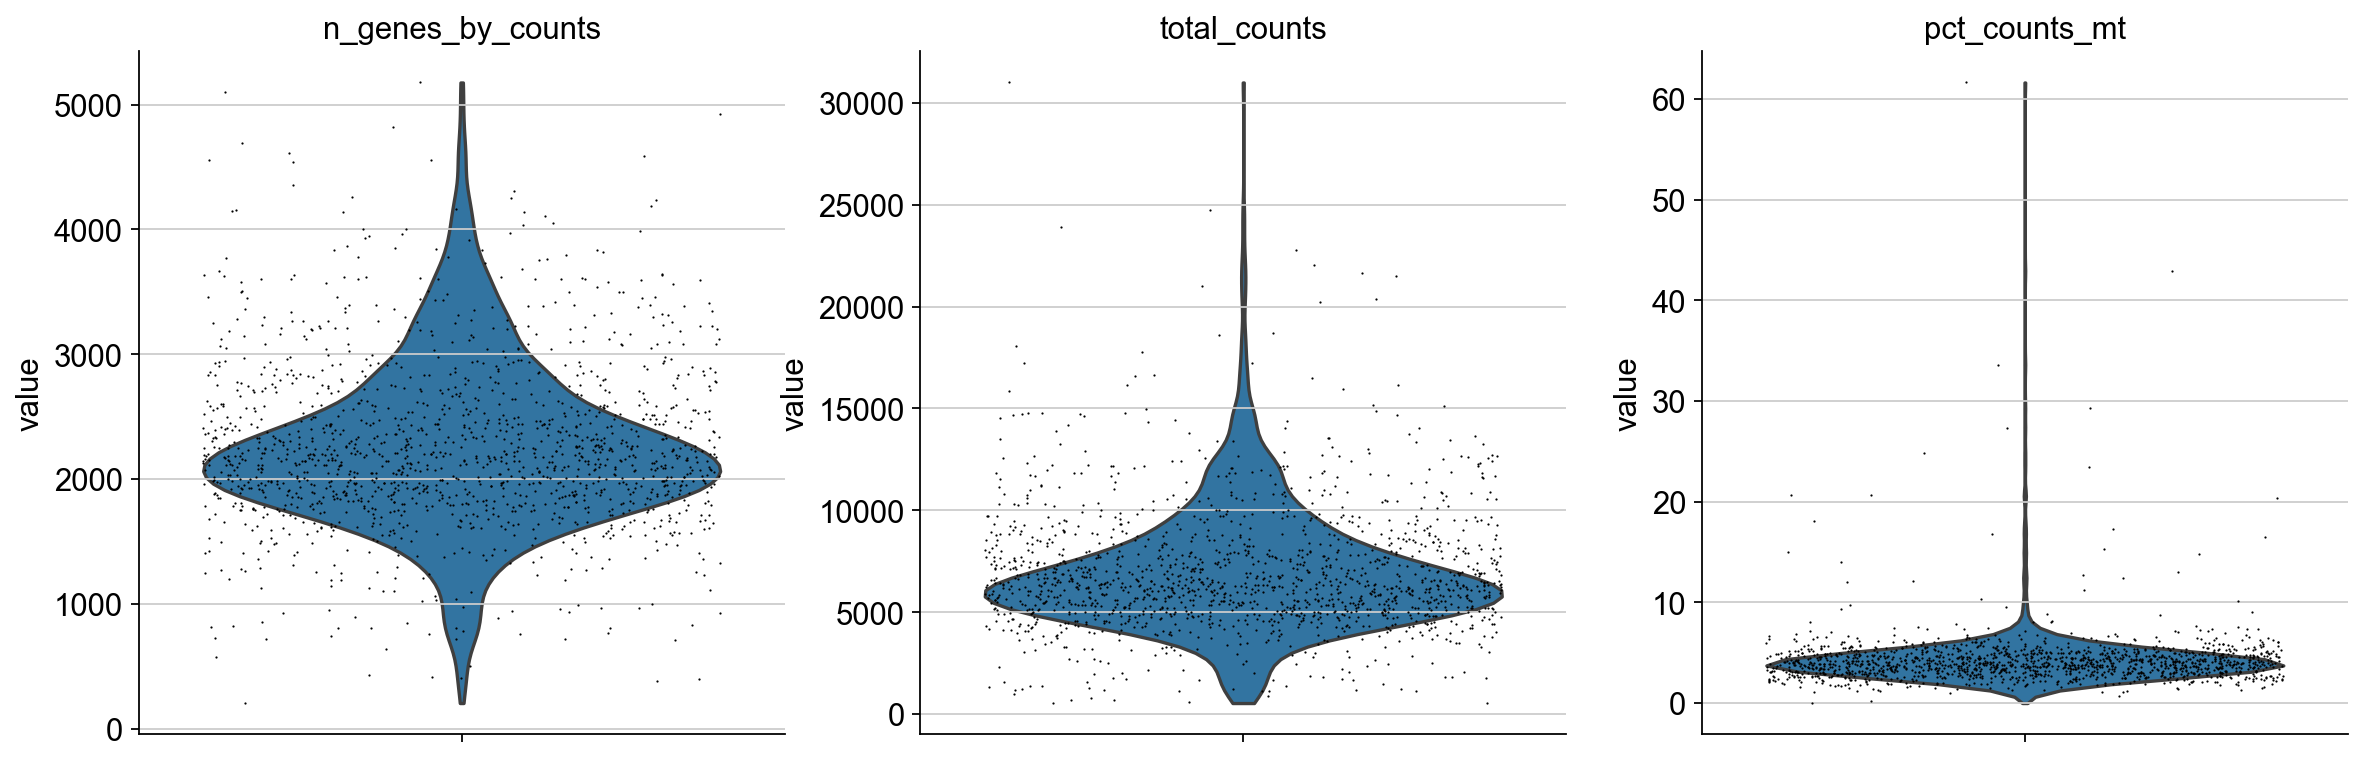

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


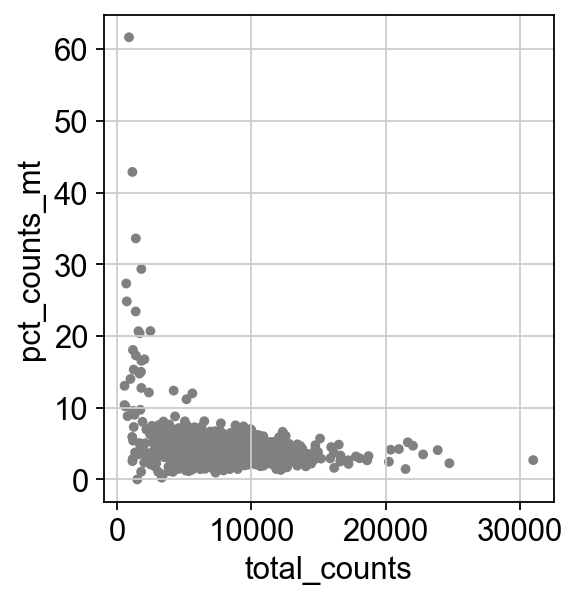

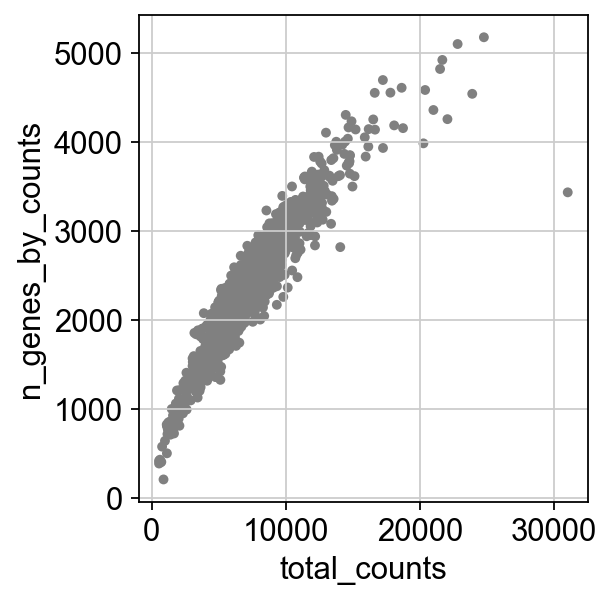

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)


normalizing counts per cell


    finished (0:00:00)


c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


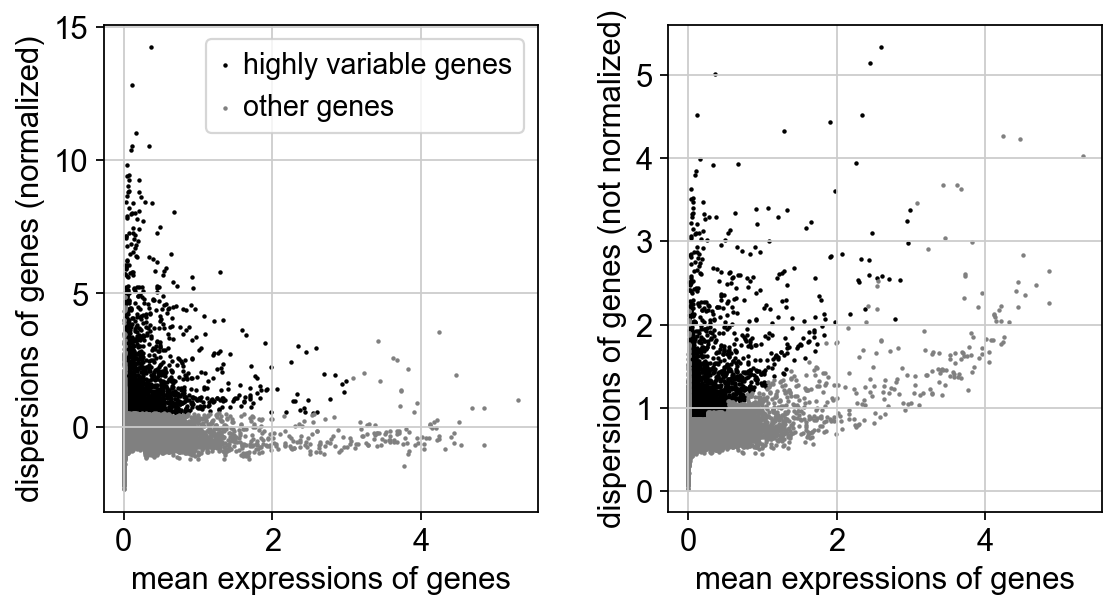

In [14]:
sc.pl.highly_variable_genes(adata)


In [15]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]


In [16]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [17]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


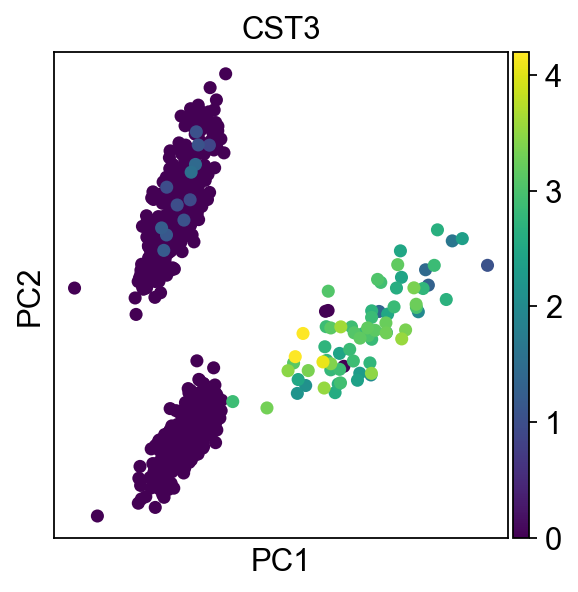

In [18]:
sc.pl.pca(adata, color='CST3')

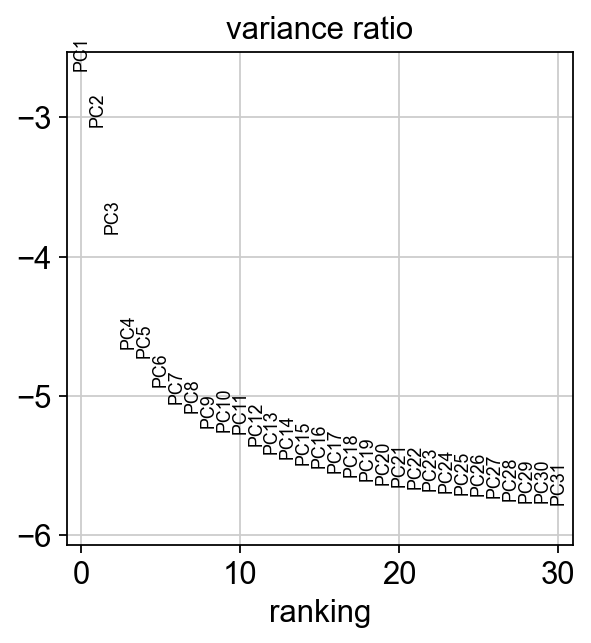

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 866 × 2504
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [22]:
sc.tl.leiden(adata, resolution=1)

running Leiden clustering


    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [23]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) #remove 'plot=False' if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [24]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


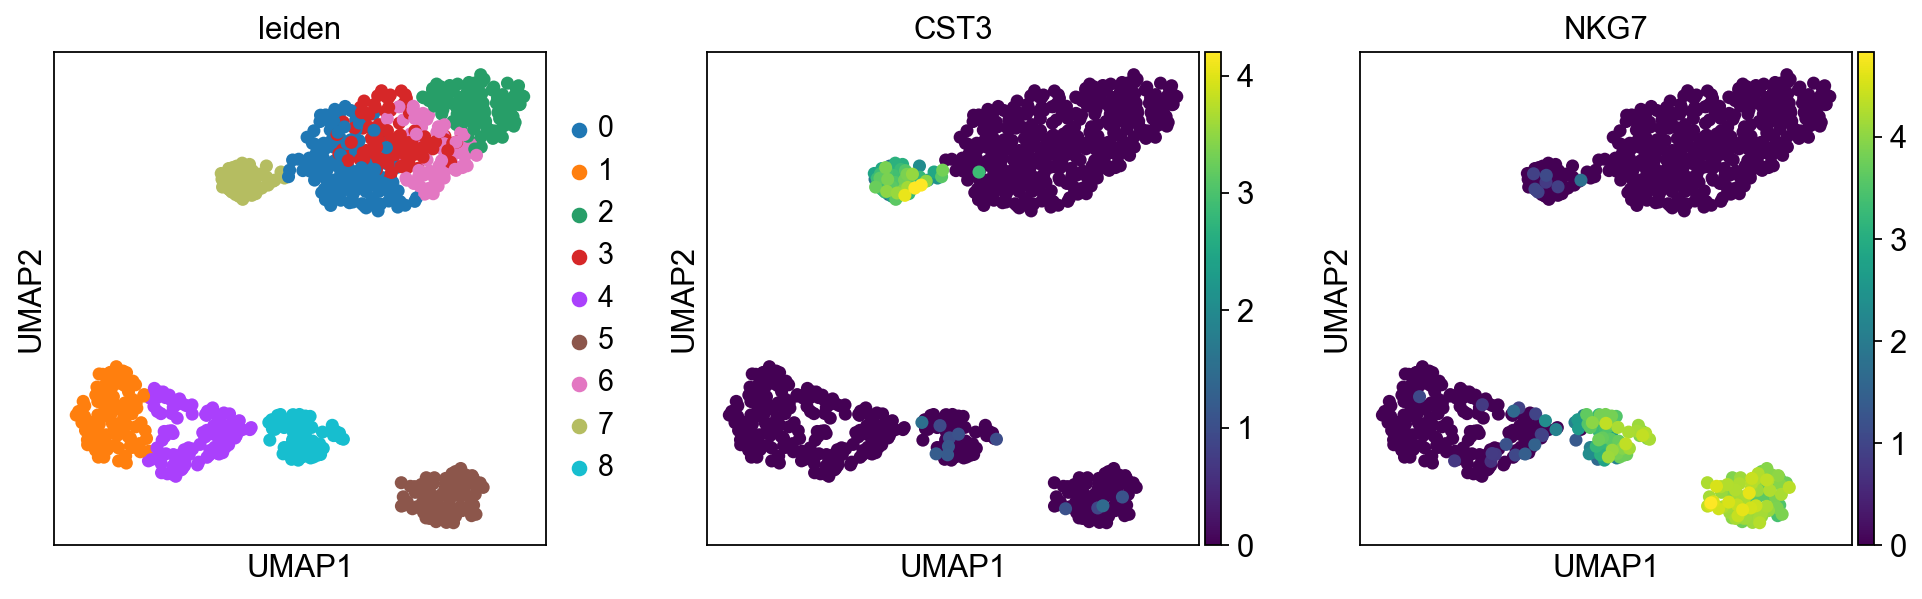

In [25]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [26]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


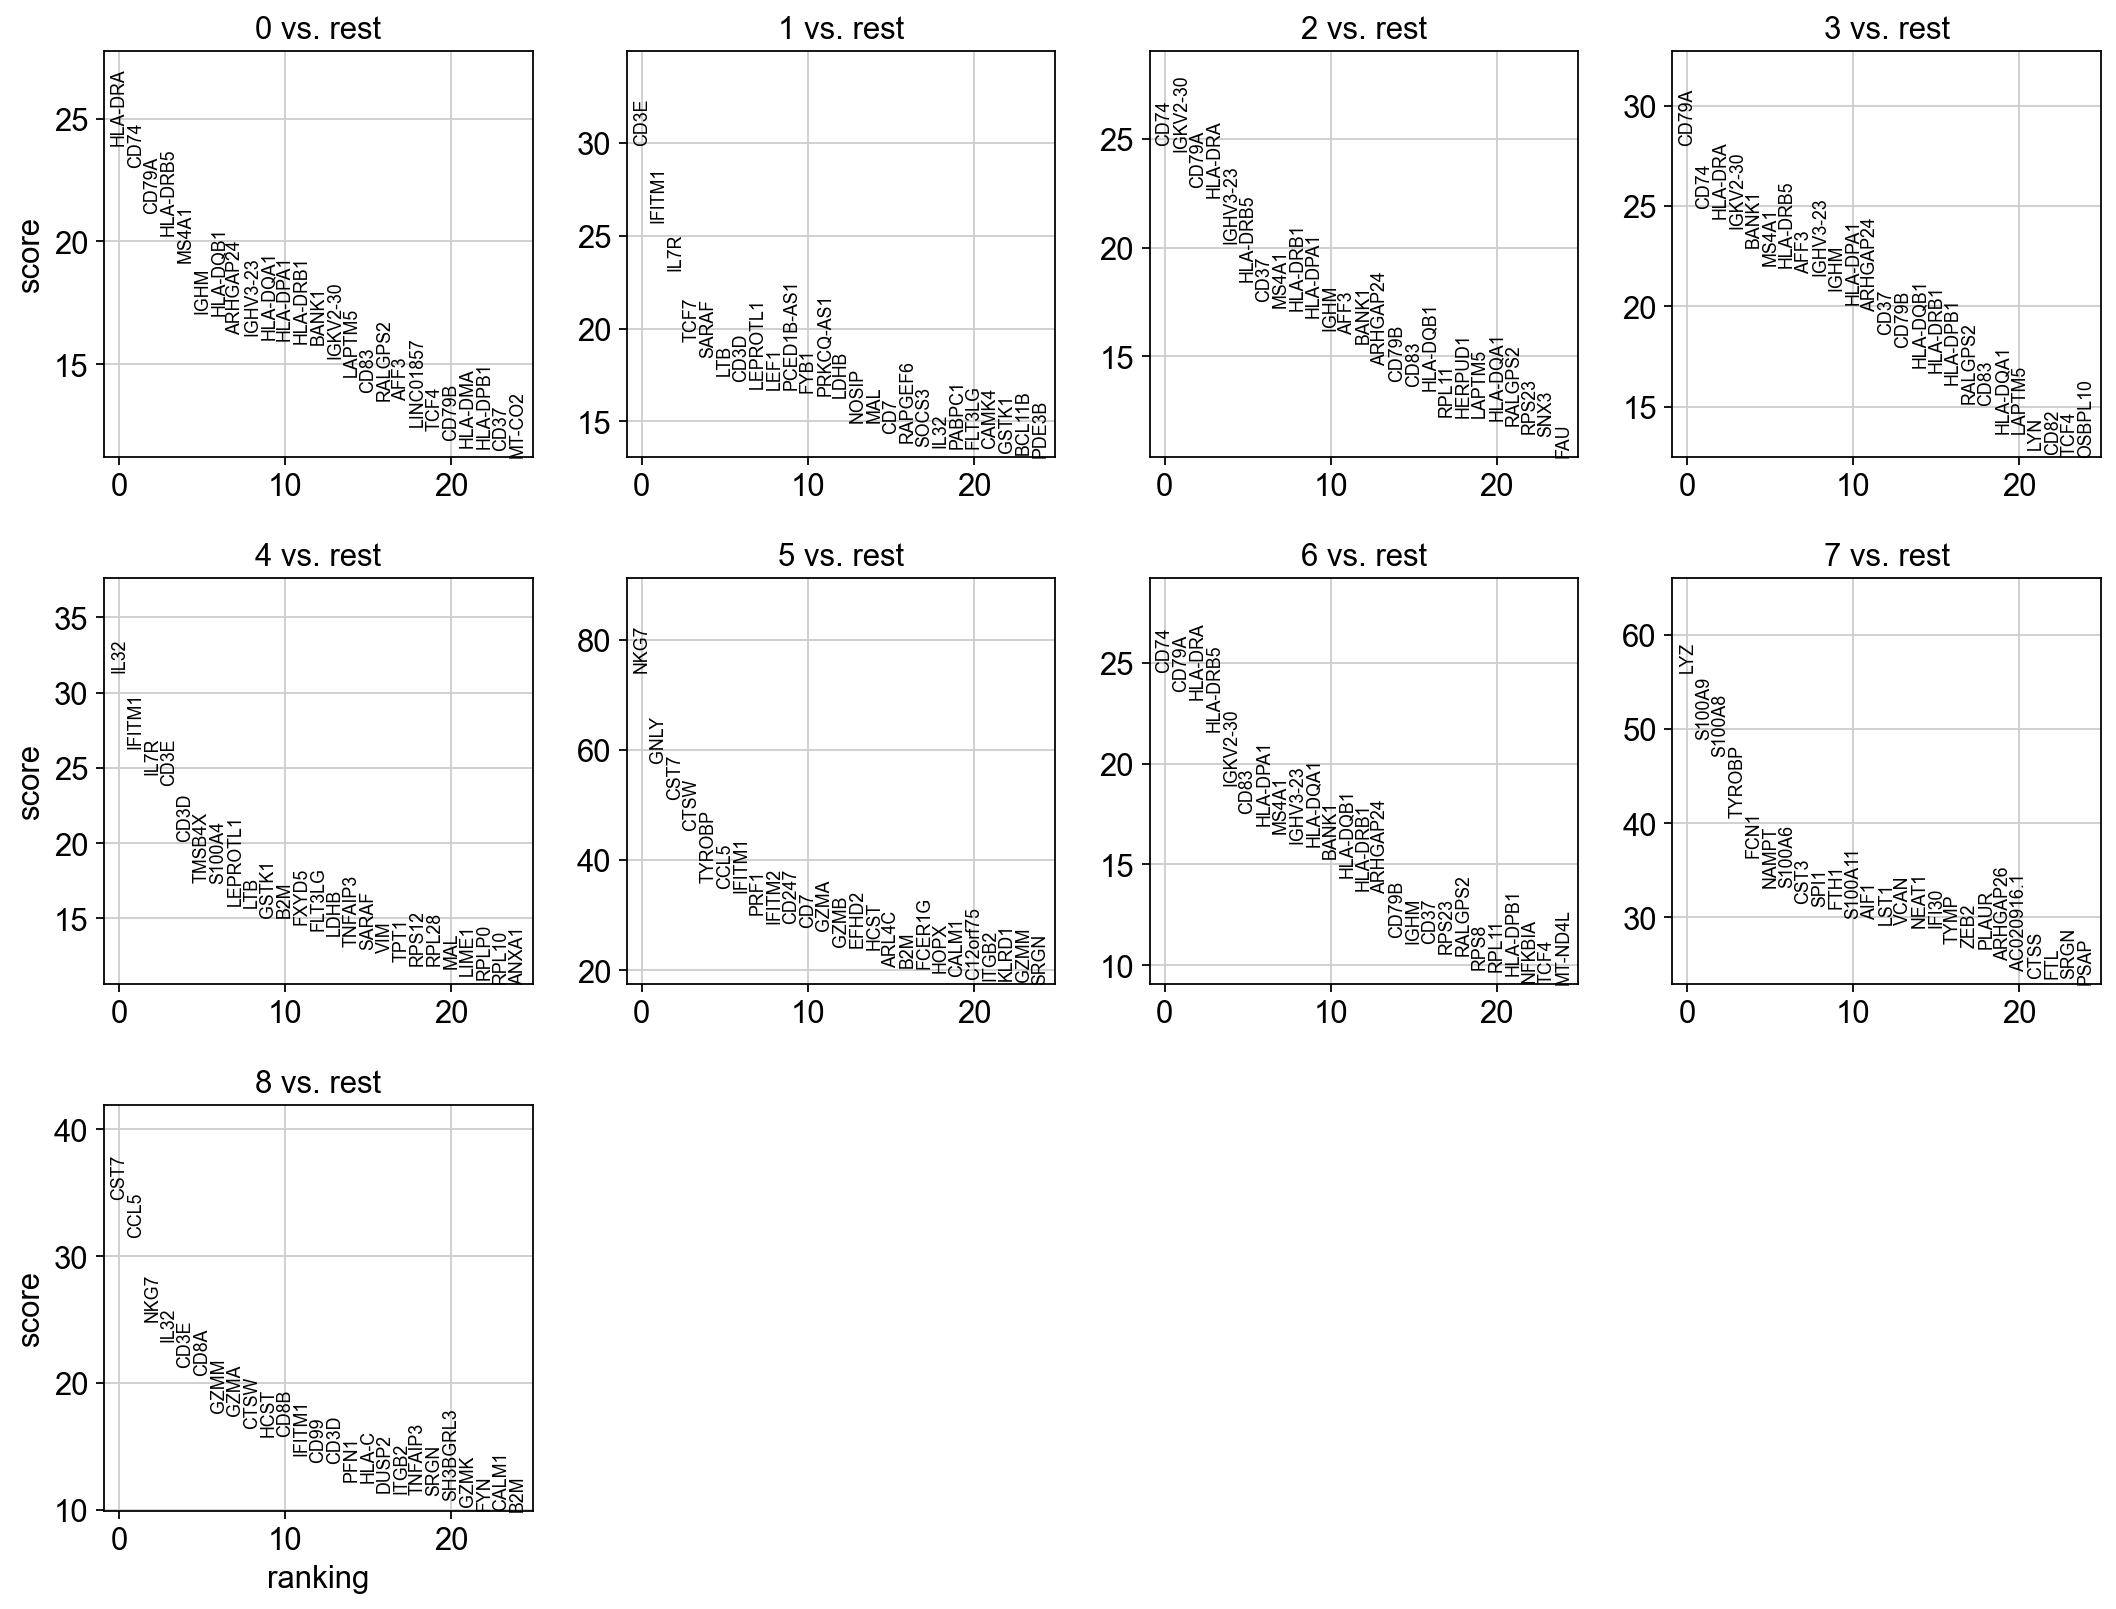

In [27]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [28]:
sc.settings.verbosity = 2 #reduce the verbosity

ranking genes
    finished (0:00:01)


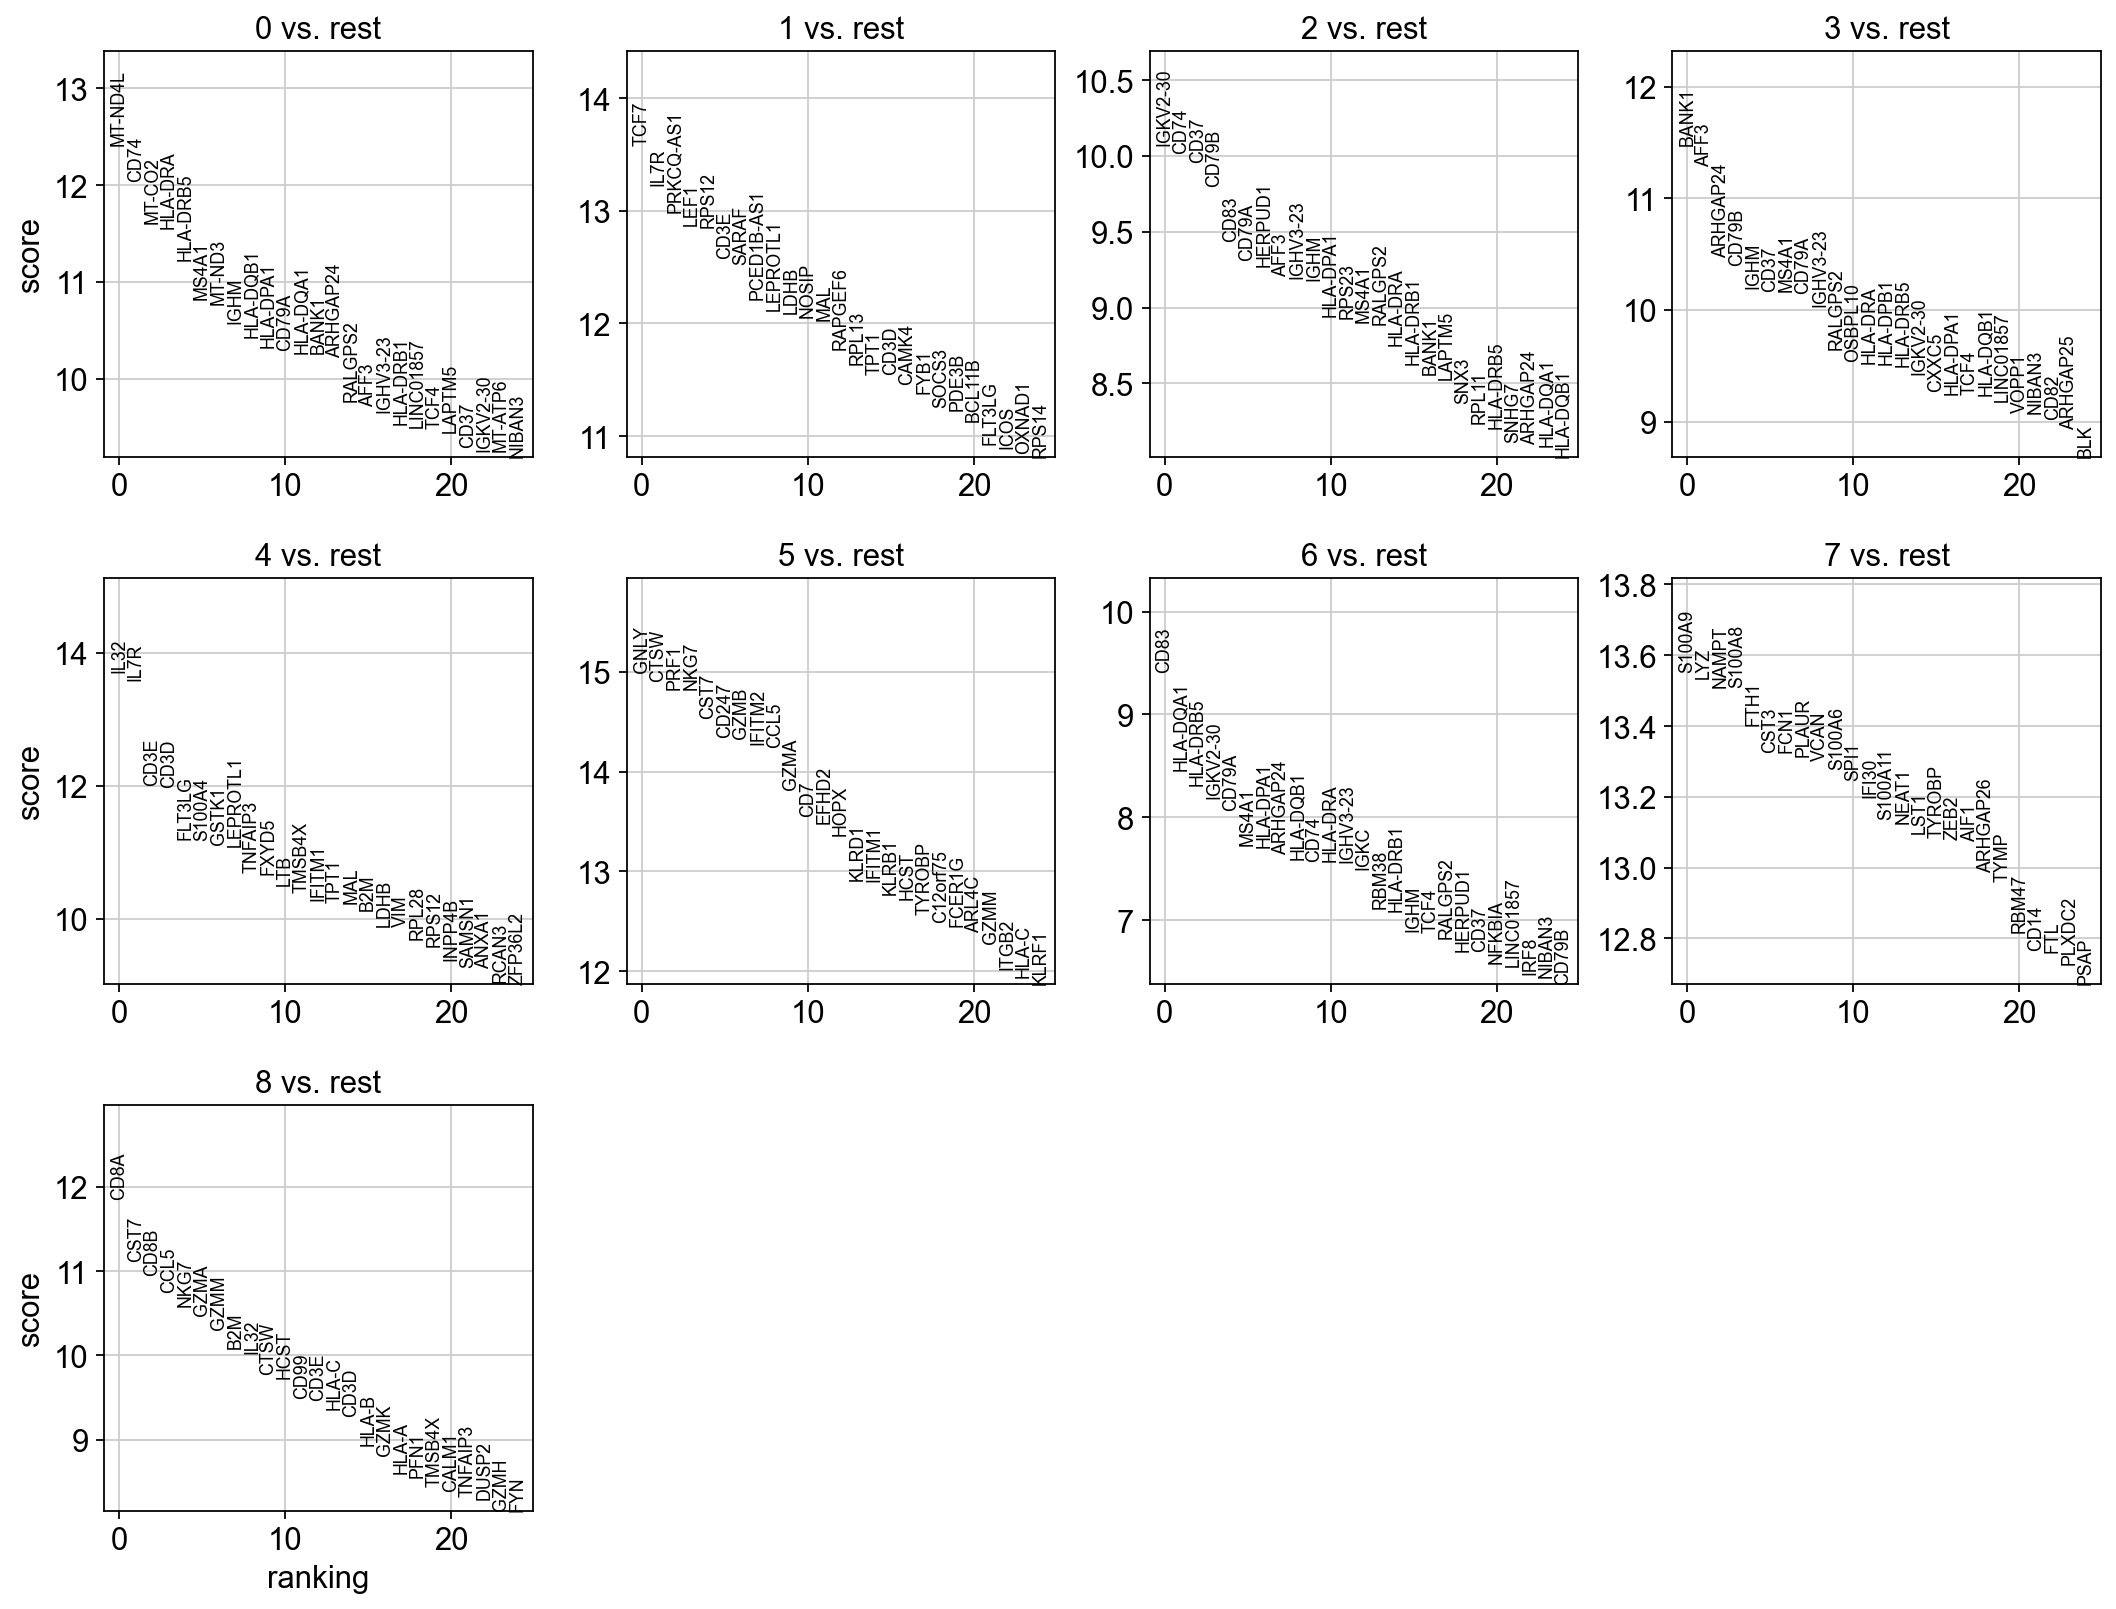

In [29]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [30]:
adata.write(results_file)

ranking genes
    finished (0:00:05)


c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


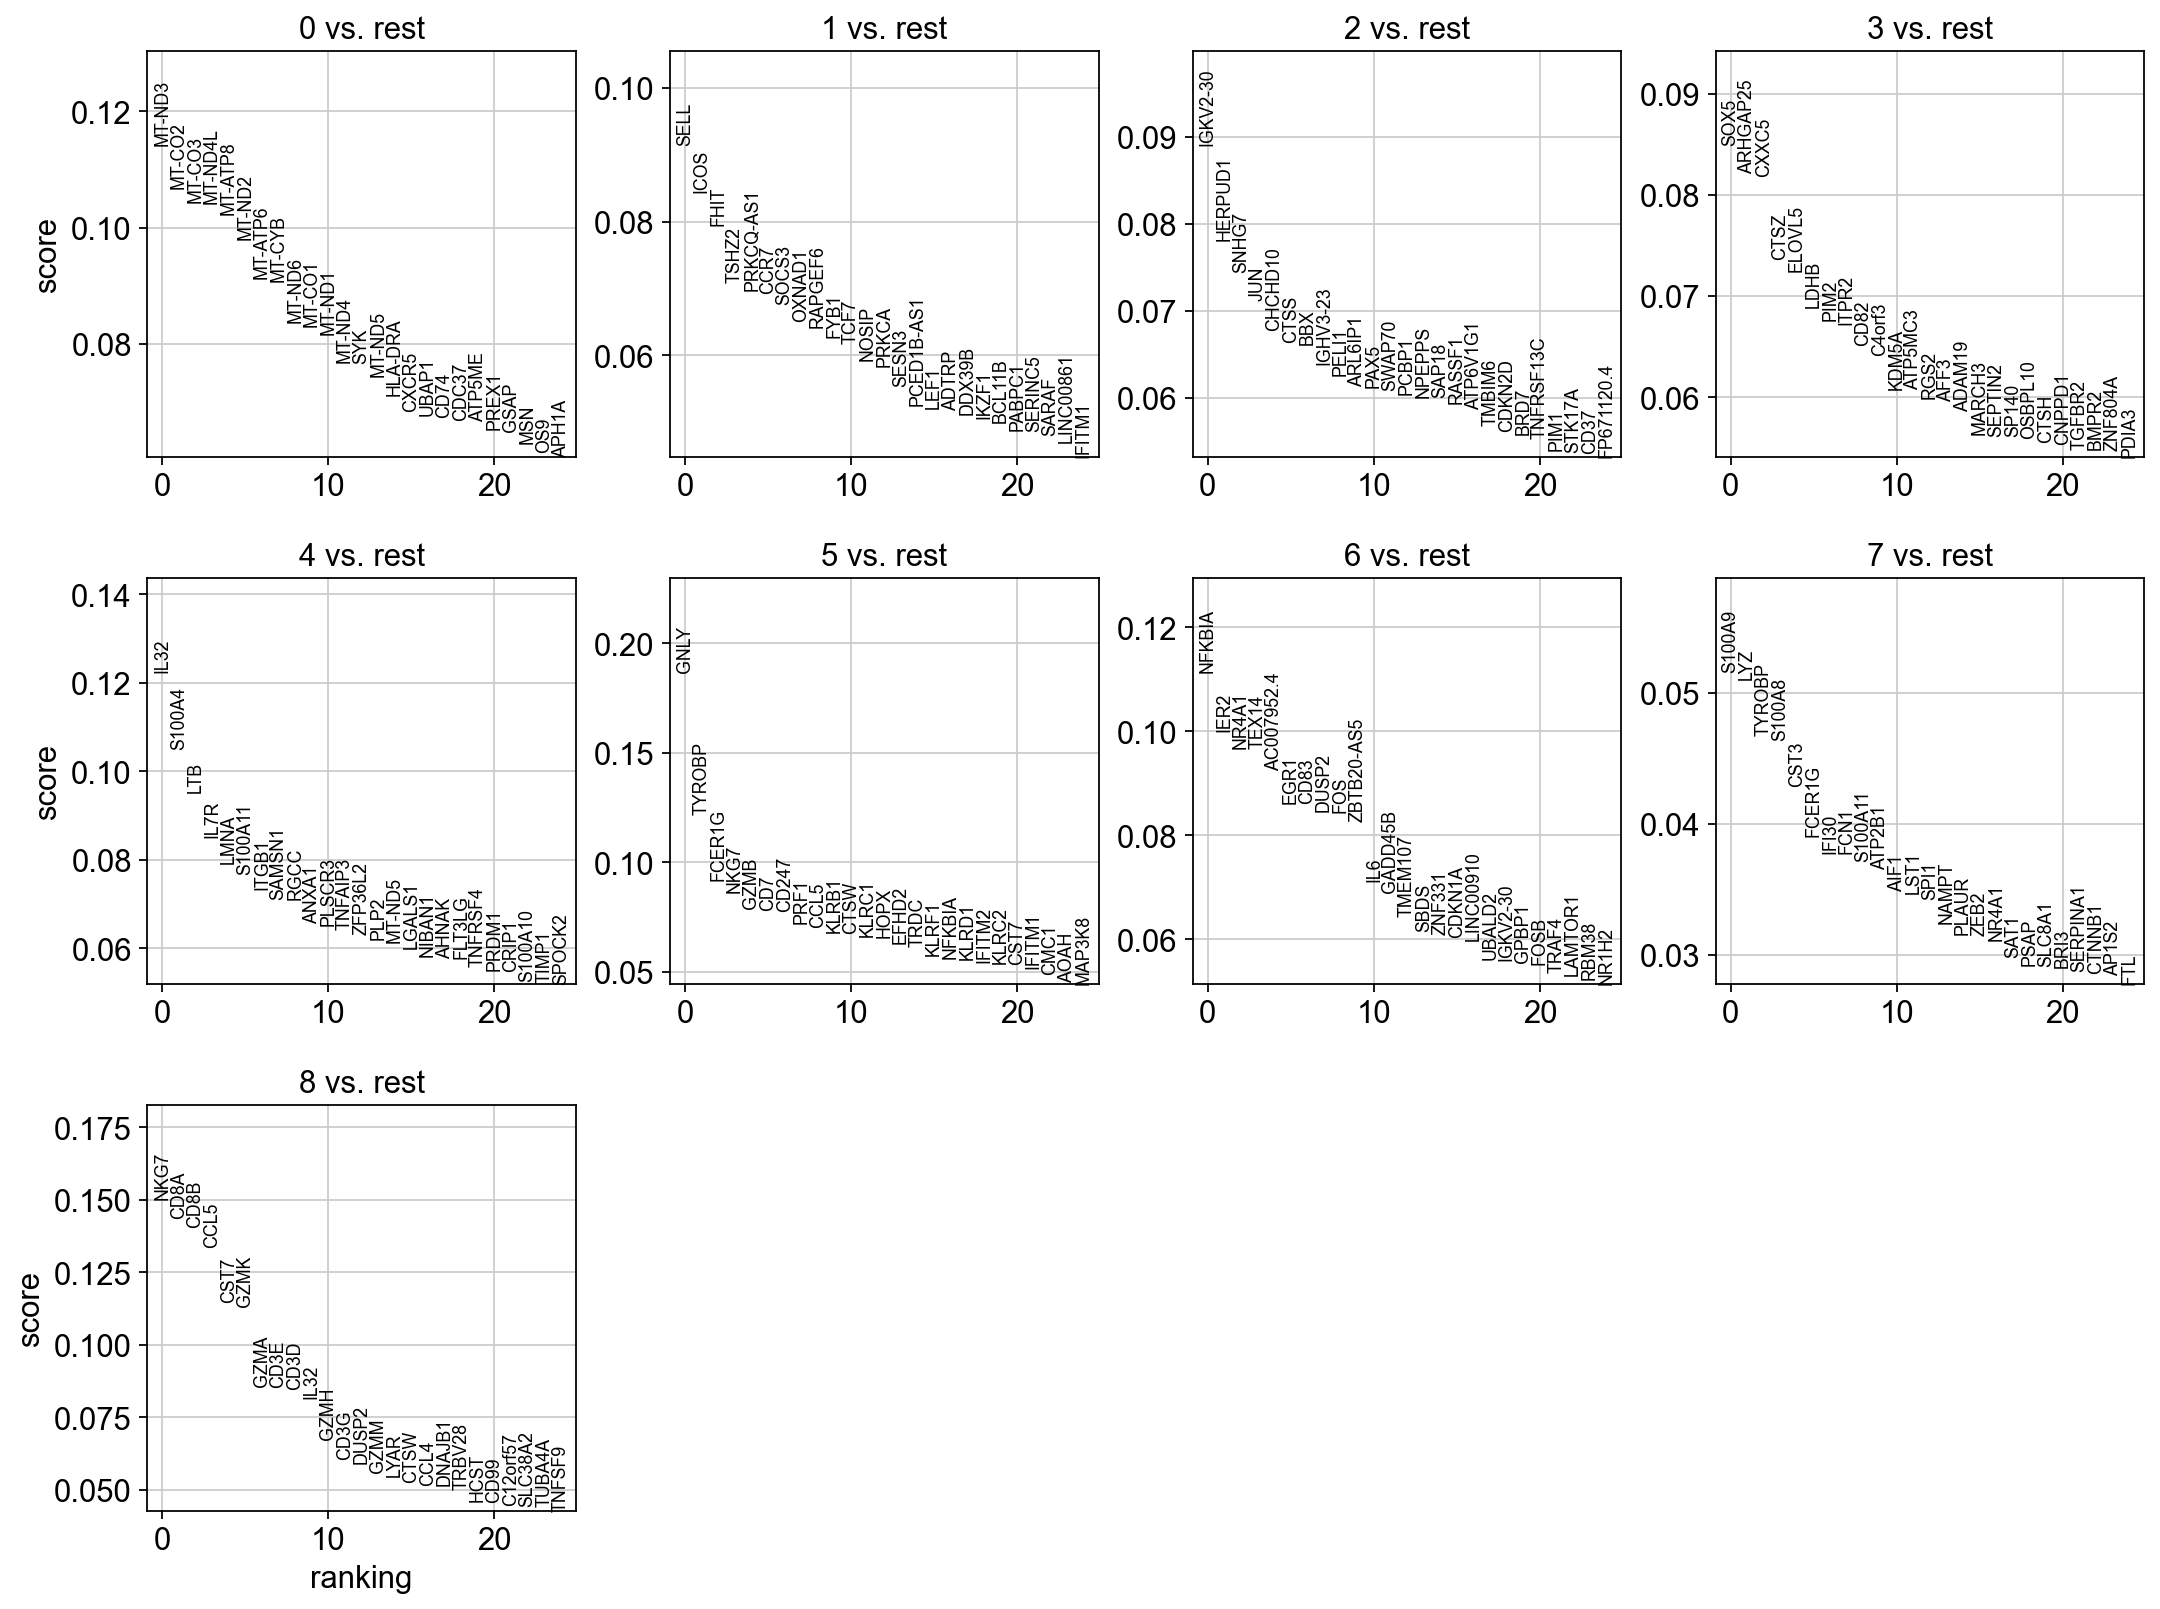

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14','LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [33]:
adata = sc.read(results_file)

In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,MT-ND4L,TCF7,IGKV2-30,BANK1,IL32,GNLY,CD83,S100A9,CD8A
1,CD74,IL7R,CD74,AFF3,IL7R,CTSW,HLA-DQA1,LYZ,CST7
2,MT-CO2,PRKCQ-AS1,CD37,ARHGAP24,CD3E,PRF1,HLA-DRB5,NAMPT,CD8B
3,HLA-DRA,LEF1,CD79B,CD79B,CD3D,NKG7,IGKV2-30,S100A8,CCL5
4,HLA-DRB5,RPS12,CD83,IGHM,FLT3LG,CST7,CD79A,FTH1,NKG7


In [35]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
     for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,MT-ND4L,2.176447e-35,TCF7,4.944649e-42,IGKV2-30,7.258493e-24,BANK1,1.680729e-30,IL32,8.093054e-43,GNLY,7.513412e-51,CD83,4.745705e-21,S100A9,7.588305e-42,CD8A,1.942001e-32
1,CD74,2.016227e-33,IL7R,6.160627e-40,CD74,1.282805e-23,AFF3,1.505335e-29,IL7R,4.066289e-42,CTSW,2.910200e-50,HLA-DQA1,2.599420e-17,LYZ,9.536354e-42,CST7,9.779632e-29
2,MT-CO2,3.848106e-31,PRKCQ-AS1,1.473210e-38,CD37,2.317066e-23,ARHGAP24,1.083513e-25,CD3E,3.060167e-33,PRF1,9.261065e-50,HLA-DRB5,9.015073e-17,NAMPT,1.366186e-41,CD8B,6.707066e-28
3,HLA-DRA,6.592453e-31,LEF1,6.580523e-38,CD79B,1.090732e-22,CD79B,2.507839e-25,CD3D,4.428127e-33,NKG7,1.007400e-49,IGKV2-30,2.558683e-16,S100A8,1.385188e-41,CCL5,6.025153e-27
4,HLA-DRB5,3.024463e-29,RPS12,8.048617e-38,CD83,3.665320e-21,IGHM,2.035446e-24,FLT3LG,3.947895e-29,CST7,7.364412e-48,CD79A,6.848995e-16,FTH1,5.873602e-41,NKG7,3.519474e-26


In [36]:
import scanpy as sc
adata = sc.read_h5ad('/Users/malon/OneDrive/Documents/GitHub/Maloney1/write/wheels_off.h5ad')
try:
    adata.uns.pop('log1p')
except:
    pass
# continue

ranking genes
    finished (0:00:00)


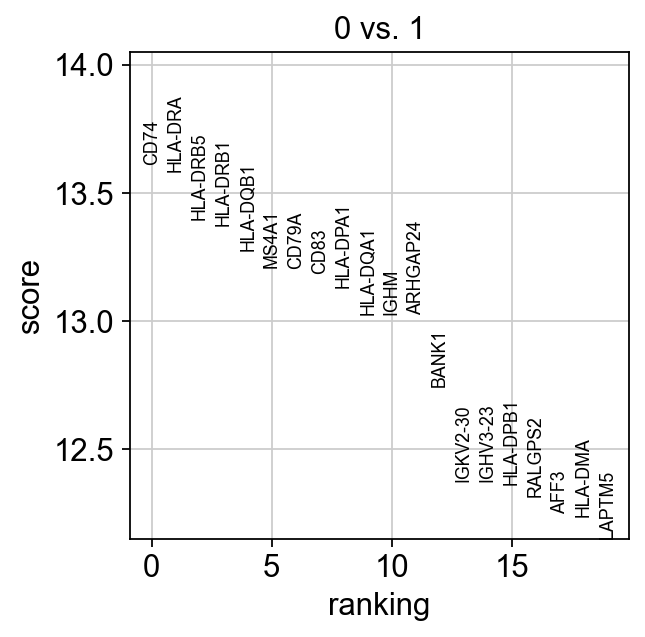

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


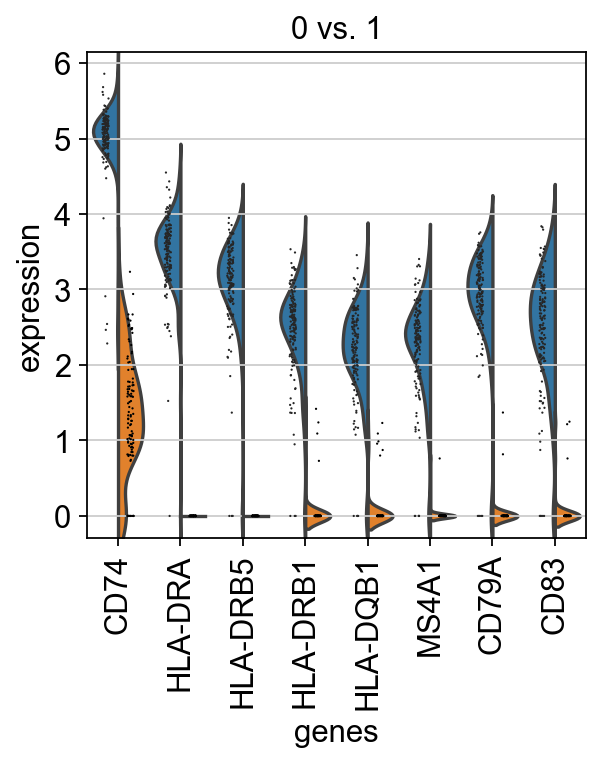

In [38]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [39]:
adata = sc.read(results_file)

c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


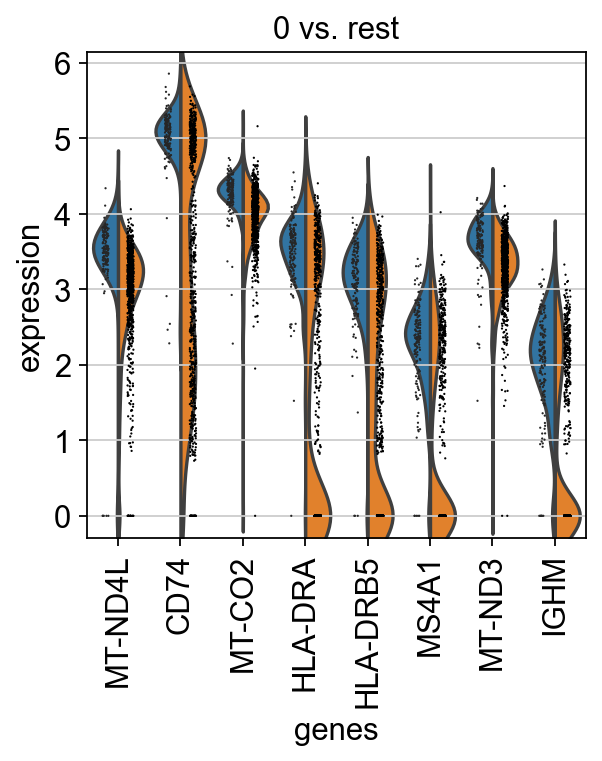

In [40]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

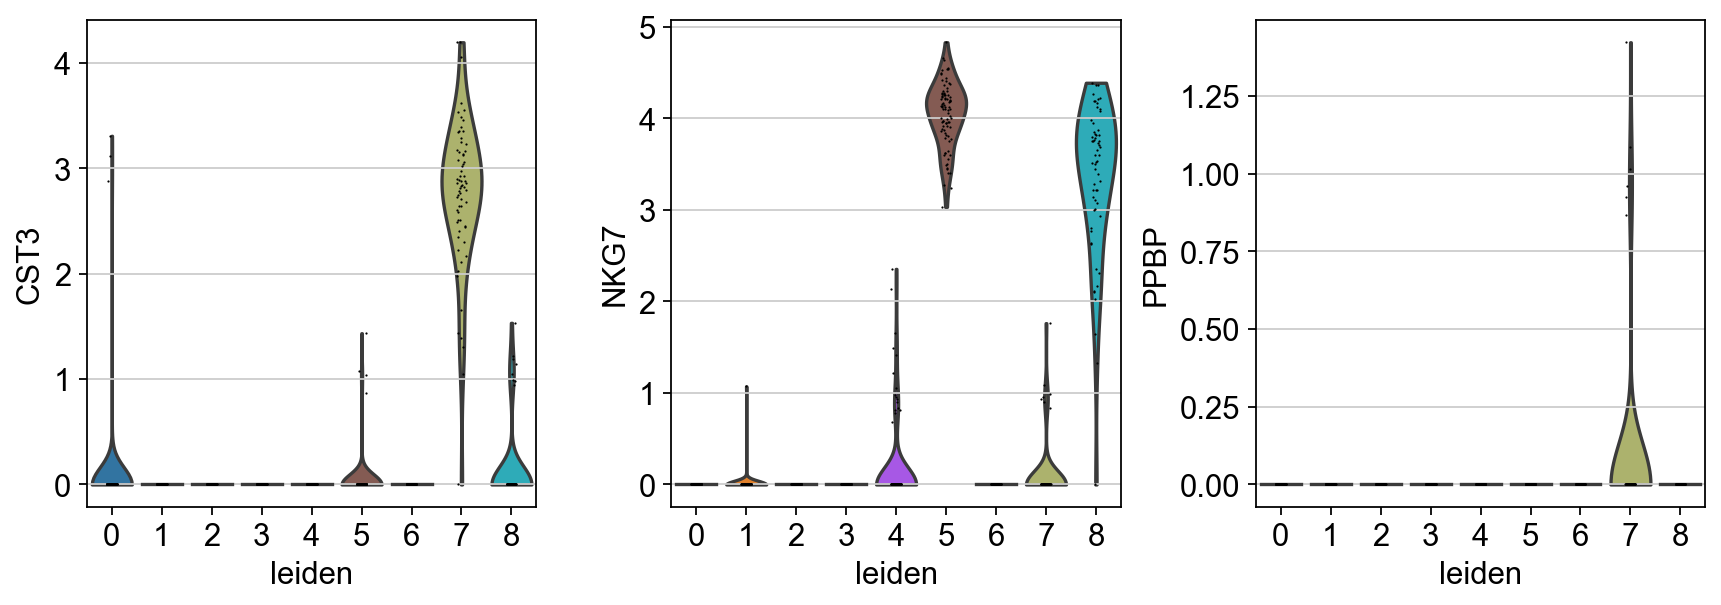

In [41]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [66]:
new_cluster_names = [
    'B(1)', 'NKT',
    'B(2)', 'B(3)',
    'CD8 T(1)', 'NK',
    'B(4)', 'CD14 Monocyte','CD8 T(2)']
adata.rename_categories('leiden', new_cluster_names)

c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


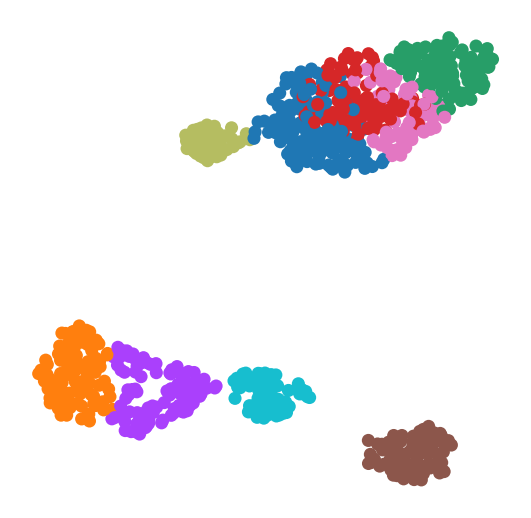

In [67]:
sc.pl.umap(adata, color='leiden', legend_loc='ondata', title='', frameon=False, save='.pdf')

c:\Users\malon\anaconda3\envs\CCHR\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


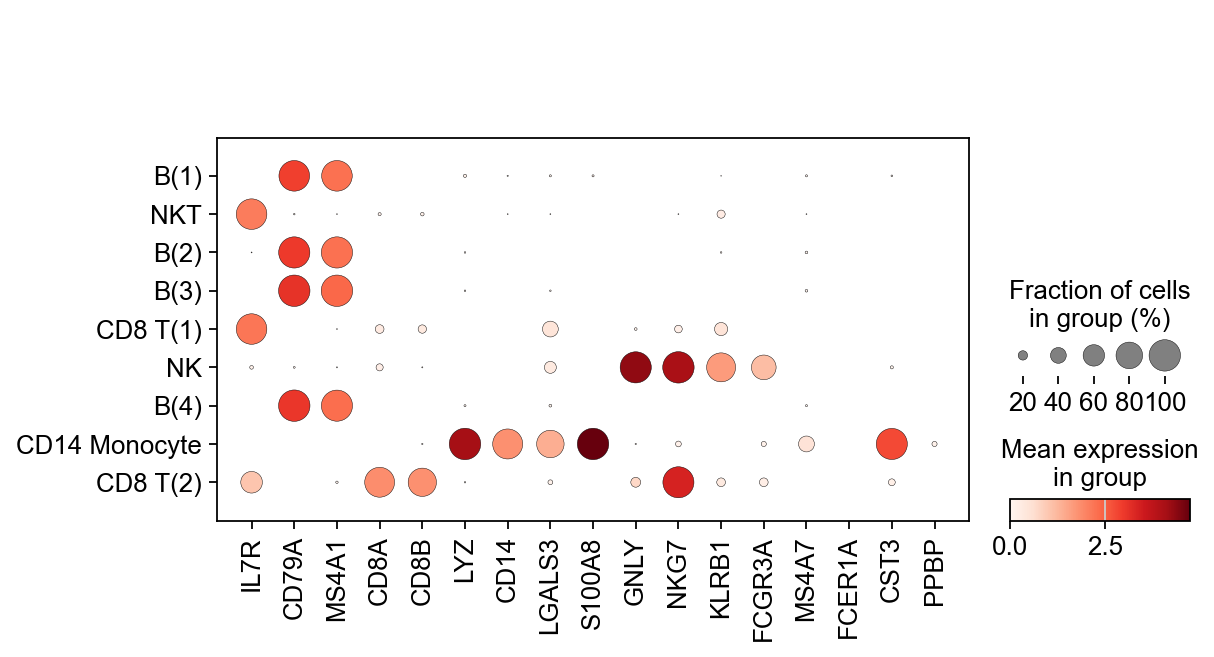

In [68]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

# sources for each of the cell markers

# b: https://www.ncbi.nlm.nih.gov/gene/931 and https://www.tandfonline.com/doi/full/10.1080/10428194.2021.1980214#:~:text=CD79a%20is%20identified%20as%20a,cell%20acute%20lymphoblastic%20leukemia%20patients.
# nkt: https://pubmed.ncbi.nlm.nih.gov/18159636/ and https://www.jbc.org/article/S0021-9258(20)62771-5/fulltext
# cd8 t: https://pubmed.ncbi.nlm.nih.gov/2122925/
# nk: simply cross-matched it with the scanpy clustering tutorial
# cd14 monocyte: also cross-matched with scanpy clustering tutorial

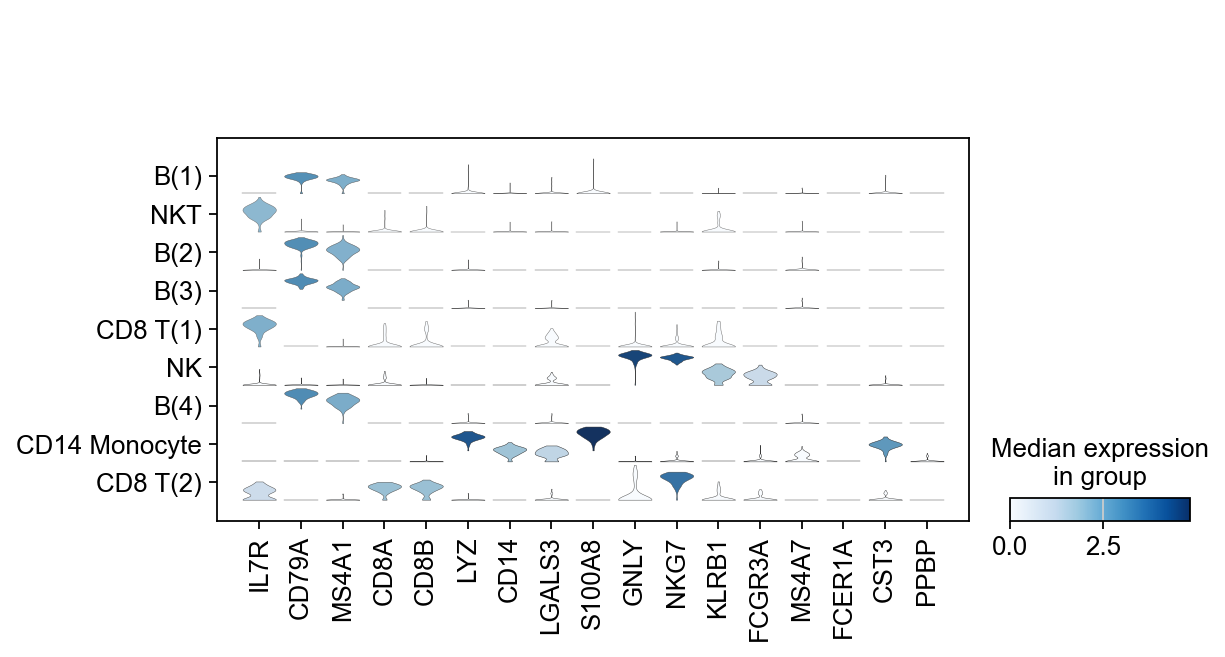

In [69]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [70]:
adata

AnnData object with n_obs × n_vars = 866 × 2504
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [71]:
adata.write(results_file, compression='gzip') #'compression='gzip'' saves disk space, but slows down writing and subsequent reading

In [72]:
adata.raw.to_adata().write('/Users/malon/OneDrive/Documents/GitHub/Maloney1/write/pbmc3k_withoutX.h5ad')

In [73]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )